In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import split,count,lower, regexp_extract
import pyspark.sql.functions as sf
import matplotlib.pyplot as plt
from pyspark.sql.types import StringType, ArrayType, StructField, StructType, IntegerType, FloatType, DoubleType
from pyspark.ml.feature import StringIndexer, VectorAssembler
# , MinMaxScaler, StandardScaler
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")
pd.set_option('display.max_columns', None)
from scipy.stats import chi2_contingency
import numpy as np
# show multiple outputs in one cell
import pickle
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder, TargetEncoder
# import train_test_split from sklearn
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from matplotlib_inline.backend_inline import set_matplotlib_formats
# set_matplotlib_formats('svg')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [4]:
# Create a SparkSession
spark = SparkSession.builder \
    .appName("LoanTap") \
    .config("spark.sql.debug.maxToStringFields", 1000) \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.sql.shuffle.partitions", 1) \
    .config("spark.network.timeout", "120s") \
    .config("spark.executor.heartbeatInterval", "10s") \
    .getOrCreate()


In [10]:
df = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .option("multiLine", "true") \
    .option("escape", "\"") \
    .csv("./logistic_regression.csv")
df.cache();

24/07/27 17:46:26 WARN CacheManager: Asked to cache already cached data.        


In [11]:
invalid_address_count = 0
def split_address(address):

    address = address.split("\n")[1]
    city,state,zipcode = "Unknown", "Unknown", "Unknown"
    try:
        if("," in address):
            # 1726 Cooper Passage Suite 129\nNorth Deniseberg, DE 30723
            # state = DE
            # city = North Deniseberg
            # zip = 30723
            city = address.split(",")[0]
            state = address.split(",")[1].split(" ")[1]
            zipcode = address.split(",")[1].split(" ")[2]
        else:
            # USCGC Tran\nFPO AP 22690
            city, state, zipcode = address.split(" ")
    except:
        global invalid_address_count
        invalid_address_count += 1
    return (city, state, zipcode)

# split_address_udf = sf.udf(split_address, ArrayType(StringType()))

split_address_udf = sf.udf(split_address, StructType([
    StructField("city", StringType(), True),
    StructField("state", StringType(), True),
    StructField("zipcode", StringType(), True)
]))

In [12]:
to_drop=[]

In [13]:
df.printSchema()

root
 |-- loan_amnt: double (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_title: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: double (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- issue_d: string (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- title: string (nullable = true)
 |-- dti: double (nullable = true)
 |-- earliest_cr_line: string (nullable = true)
 |-- open_acc: double (nullable = true)
 |-- pub_rec: double (nullable = true)
 |-- revol_bal: double (nullable = true)
 |-- revol_util: double (nullable = true)
 |-- total_acc: double (nullable = true)
 |-- initial_list_status: string (nullable = true)
 |-- application_type: string (nullable 

In [14]:
df.limit(5).toPandas()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,Not Verified,Jan-2015,Fully Paid,vacation,Vacation,26.24,Jun-1990,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,Not Verified,Jan-2015,Fully Paid,debt_consolidation,Debt consolidation,22.05,Jul-2004,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,Source Verified,Jan-2015,Fully Paid,credit_card,Credit card refinancing,12.79,Aug-2007,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,Not Verified,Nov-2014,Fully Paid,credit_card,Credit card refinancing,2.60,Sep-2006,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,Verified,Apr-2013,Charged Off,credit_card,Credit Card Refinance,33.95,Mar-1999,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\nGreggshire, VA 11650"


# Data Cleaning

In [15]:
# Null values in each column
for col in df.columns:
    print(col," : ", df.filter(df[col].isNull()).count())

loan_amnt  :  0
term  :  0
int_rate  :  0
installment  :  0
grade  :  0
sub_grade  :  0
emp_title  :  22927
emp_length  :  18301
home_ownership  :  0
annual_inc  :  0
verification_status  :  0
issue_d  :  0
loan_status  :  0
purpose  :  0
title  :  1755
dti  :  0
earliest_cr_line  :  0
open_acc  :  0
pub_rec  :  0
revol_bal  :  0
revol_util  :  276
total_acc  :  0
initial_list_status  :  0
application_type  :  0
mort_acc  :  37795
pub_rec_bankruptcies  :  535
address  :  0


In [16]:
df.select("revol_util").summary().show();

+-------+------------------+
|summary|        revol_util|
+-------+------------------+
|  count|            395754|
|   mean| 53.79174863677853|
| stddev|24.452193062711693|
|    min|               0.0|
|    25%|              35.8|
|    50%|              54.8|
|    75%|              72.9|
|    max|             892.3|
+-------+------------------+



In [17]:
df.select("mort_acc").summary().show();

+-------+------------------+
|summary|          mort_acc|
+-------+------------------+
|  count|            358235|
|   mean|1.8139908160844138|
| stddev|2.1479304671233352|
|    min|               0.0|
|    25%|               0.0|
|    50%|               1.0|
|    75%|               3.0|
|    max|              34.0|
+-------+------------------+



In [18]:
df.select("home_ownership").distinct().show()

+--------------+
|home_ownership|
+--------------+
|          RENT|
|      MORTGAGE|
|           OWN|
|         OTHER|
|          NONE|
|           ANY|
+--------------+



In [19]:
df = df.withColumn(
        "mort_acc",
        sf.when(
            (sf.col("home_ownership") == "MORTGAGE") & (sf.col("mort_acc").isNull()), 
            1
        ).otherwise(sf.col("mort_acc"))
    )
df=df.fillna(0, subset=["mort_acc", "pub_rec_bankruptcies", "revol_util"])
df = df.drop("title")

df=df.withColumn("split_address", split_address_udf("address"))

In [20]:
df.select("split_address").show(20, False)

+--------------------------------+
|split_address                   |
+--------------------------------+
|{Mendozaberg, OK, 22690}        |
|{Loganmouth, SD, 05113}         |
|{New Sabrina, WV, 05113}        |
|{Delacruzside, MA, 00813}       |
|{Greggshire, VA, 11650}         |
|{North Deniseberg, DE, 30723}   |
|{East Stephanie, TX, 22690}     |
|{FPO, AE, 30723}                |
|{FPO, AP, 22690}                |
|{Mauricestad, VA, 00813}        |
|{Bartlettfort, NM, 00813}       |
|{South Matthew, MS, 00813}      |
|{West Beckyfort, MS, 70466}     |
|{Shellychester, OR, 29597}      |
|{Lake Andrew, NH, 29597}        |
|{Stevenfort, HI, 30723}         |
|{West Aprilborough, PA, 00813}  |
|{Cummingsshire, NH, 30723}      |
|{Port Kirstenborough, CO, 70466}|
|{DPO, AE, 05113}                |
+--------------------------------+
only showing top 20 rows



In [21]:
df = df.withColumn("city", sf.col("split_address.city")) \
       .withColumn("state", sf.col("split_address.state")) \
       .withColumn("zipcode", sf.col("split_address.zipcode")) \
       .drop("split_address")
df=df.drop("address")

In [22]:
df.groupBy('loan_status').count().show()

+-----------+------+
|loan_status| count|
+-----------+------+
| Fully Paid|318357|
|Charged Off| 77673|
+-----------+------+



In [23]:
df.groupBy("term").count().show()

+----------+------+
|      term| count|
+----------+------+
| 36 months|302005|
| 60 months| 94025|
+----------+------+



In [24]:
split_col = split(df['term'], " ", -1)
df= df.withColumn('term', split_col.getItem(1))

In [25]:
df.groupBy('emp_title').count().sort('count', ascending=False).show()

+--------------------+-----+
|           emp_title|count|
+--------------------+-----+
|                NULL|22927|
|             Teacher| 4389|
|             Manager| 4250|
|    Registered Nurse| 1856|
|                  RN| 1846|
|          Supervisor| 1830|
|               Sales| 1638|
|     Project Manager| 1505|
|               Owner| 1410|
|              Driver| 1339|
|      Office Manager| 1218|
|             manager| 1145|
|            Director| 1089|
|     General Manager| 1074|
|            Engineer|  995|
|             teacher|  962|
|              driver|  882|
|      Vice President|  857|
|  Operations Manager|  763|
|Administrative As...|  756|
+--------------------+-----+
only showing top 20 rows



In [26]:
df = df.withColumn("emp_title", lower(df["emp_title"]))
# replace Null values with 'unknown'
df = df.fillna('unknown', subset=['emp_title'])

In [27]:
df.groupBy('emp_title').count().sort('count', ascending=False).show()

+------------------+-----+
|         emp_title|count|
+------------------+-----+
|           unknown|22927|
|           manager| 5637|
|           teacher| 5430|
|  registered nurse| 2627|
|        supervisor| 2591|
|             sales| 2382|
|            driver| 2306|
|             owner| 2201|
|                rn| 2074|
|   project manager| 1776|
|    office manager| 1638|
|   general manager| 1461|
|      truck driver| 1288|
|          director| 1192|
|          engineer| 1188|
|    police officer| 1041|
|    vice president|  962|
|operations manager|  961|
|     sales manager|  961|
|     store manager|  941|
+------------------+-----+
only showing top 20 rows



In [28]:
df.groupBy('emp_length').count().sort('count', ascending=False).show()

+----------+------+
|emp_length| count|
+----------+------+
| 10+ years|126041|
|   2 years| 35827|
|  < 1 year| 31725|
|   3 years| 31665|
|   5 years| 26495|
|    1 year| 25882|
|   4 years| 23952|
|   6 years| 20841|
|   7 years| 20819|
|   8 years| 19168|
|      NULL| 18301|
|   9 years| 15314|
+----------+------+



In [29]:
df = df.withColumn('emp_length', regexp_extract(df['emp_length'], r'(\d+)', 1))

# df.groupBy('grade').avg('emp_length').show()
avg_emp_length=df.groupBy("grade").agg(sf.avg("emp_length").cast("int").alias("avg_emp_length"))

df=df.join(avg_emp_length, "grade", )

df = df.withColumn(
        "emp_length",
        sf.when(
             sf.col("emp_length").isNull(), 
            sf.col("avg_emp_length")
        ).otherwise(sf.col("emp_length"))
    )

df = df.withColumn("emp_length", df["emp_length"].cast(IntegerType()))
df=df.drop("avg_emp_length")

In [30]:
df.groupBy("purpose").count().sort('count', ascending=False).show()

+------------------+------+
|           purpose| count|
+------------------+------+
|debt_consolidation|234507|
|       credit_card| 83019|
|  home_improvement| 24030|
|             other| 21185|
|    major_purchase|  8790|
|    small_business|  5701|
|               car|  4697|
|           medical|  4196|
|            moving|  2854|
|          vacation|  2452|
|             house|  2201|
|           wedding|  1812|
|  renewable_energy|   329|
|       educational|   257|
+------------------+------+



In [31]:
df.groupBy("grade").count().sort('count', ascending=False).show()

+-----+------+
|grade| count|
+-----+------+
|    B|116018|
|    C|105987|
|    A| 64187|
|    D| 63524|
|    E| 31488|
|    F| 11772|
|    G|  3054|
+-----+------+



In [32]:
df.groupBy('sub_grade').count().sort('count', ascending=False).show();

+---------+-----+
|sub_grade|count|
+---------+-----+
|       B3|26655|
|       B4|25601|
|       C1|23662|
|       C2|22580|
|       B2|22495|
|       B5|22085|
|       C3|21221|
|       C4|20280|
|       B1|19182|
|       A5|18526|
|       C5|18244|
|       D1|15993|
|       A4|15789|
|       D2|13951|
|       D3|12223|
|       D4|11657|
|       A3|10576|
|       A1| 9729|
|       D5| 9700|
|       A2| 9567|
+---------+-----+
only showing top 20 rows



In [33]:
# convert issue_d havimg format of Jan-2015 to date
df = df.withColumn("issue_d", sf.to_date(df["issue_d"], "MMM-yyyy"))
df = df.withColumn("earliest_cr_line", sf.to_date(df["issue_d"], "MMM-yyyy"))
# extract year from issue_d
df = df.withColumn("issue_year", sf.year(df["issue_d"]))
df = df.withColumn("earliest_cr_line_year", sf.year(df["earliest_cr_line"]))
# extract month in form of integer from issue_d
df = df.withColumn("issue_month", sf.month(df["issue_d"]))
df = df.withColumn("earliest_cr_line_month", sf.month(df["earliest_cr_line"]))

In [34]:
# # convert multiple colums to int
# df = df.withColumn("earliest_cr_line_year", df["issue_month"].cast(IntegerType()))
# df = df.withColumn("issue_year", df["issue_year"].cast(IntegerType()))

In [35]:
to_drop.extend(['issue_d', 'earliest_cr_line'])

In [36]:
# drop duplicates
df = df.dropDuplicates()

In [37]:
float_cols = [col for col in df.columns if isinstance(df.schema[col].dataType, (DoubleType, FloatType))]
float_cols

['loan_amnt',
 'int_rate',
 'installment',
 'annual_inc',
 'dti',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'mort_acc',
 'pub_rec_bankruptcies']

In [38]:
# convert to int
df=df.withColumn("annual_inc", df["annual_inc"].cast(IntegerType()))
df=df.withColumn("open_acc", df["open_acc"].cast(IntegerType()))
df=df.withColumn("pub_rec", df["pub_rec"].cast(IntegerType()))
df=df.withColumn("total_acc", df["total_acc"].cast(IntegerType()))
df=df.withColumn("mort_acc", df["mort_acc"].cast(IntegerType()))
df=df.withColumn("pub_rec", df["pub_rec"].cast(IntegerType()))
df=df.withColumn("pub_rec_bankruptcies", df["pub_rec_bankruptcies"].cast(IntegerType()))
df=df.withColumn("revol_bal", df["revol_bal"].cast(IntegerType()))

In [39]:
for col in df.columns:
    print(col," : ", df.filter(df[col].isNull()).count())

grade  :  0
loan_amnt  :  0
term  :  0
int_rate  :  0
installment  :  0
sub_grade  :  0
emp_title  :  0


emp_length  :  0
home_ownership  :  0
annual_inc  :  0
verification_status  :  0


issue_d  :  0
loan_status  :  0
purpose  :  0
dti  :  0


earliest_cr_line  :  0
open_acc  :  0
pub_rec  :  0
revol_bal  :  0
revol_util  :  0
total_acc  :  0
initial_list_status  :  0
application_type  :  0
mort_acc  :  0
pub_rec_bankruptcies  :  0


city  :  0


state  :  0


zipcode  :  0
issue_year  :  0


earliest_cr_line_year  :  0
issue_month  :  0
earliest_cr_line_month  :  0


In [40]:
# save to csv
df.write.csv("logistic_regression_cleaned.csv", header=True, mode='overwrite')
# save as parquet
df.write.parquet("logistic_regression_cleaned.parquet", mode='overwrite')

# EDA

In [5]:
df = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .option("multiLine", "true") \
    .option("escape", "\"") \
    .csv("./logistic_regression_cleaned.csv")
df.cache();

In [7]:
df.createOrReplaceTempView("data")
pdf = df.toPandas();

In [6]:
pdf.head()

,grade,loan_amnt,term,int_rate,installment,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,city,state,zipcode,issue_year,earliest_cr_line_year,issue_month,earliest_cr_line_month
0,B,10000.0,36,11.44,329.48,B4,marketing,10,RENT,117000,Not Verified,2015-01-01,Fully Paid,vacation,26.24,2015-01-01,16,0,36369,41.8,25,w,INDIVIDUAL,0,0,Mendozaberg,OK,22690,2015,2015,1,1
1,B,8000.0,36,11.99,265.68,B5,credit analyst,4,MORTGAGE,65000,Not Verified,2015-01-01,Fully Paid,debt_consolidation,22.05,2015-01-01,17,0,20131,53.3,27,f,INDIVIDUAL,3,0,Loganmouth,SD,5113,2015,2015,1,1
2,B,15600.0,36,10.49,506.97,B3,statistician,1,RENT,43057,Source Verified,2015-01-01,Fully Paid,credit_card,12.79,2015-01-01,13,0,11987,92.2,26,f,INDIVIDUAL,0,0,New Sabrina,WV,5113,2015,2015,1,1
3,A,7200.0,36,6.49,220.65,A2,client advocate,6,RENT,54000,Not Verified,2014-11-01,Fully Paid,credit_card,2.60,2014-11-01,6,0,5472,21.5,13,f,INDIVIDUAL,0,0,Delacruzside,MA,813,2014,2014,11,11
4,C,24375.0,60,17.27,609.33,C5,destiny management inc.,9,MORTGAGE,55000,Verified,2013-04-01,Charged Off,credit_card,33.95,2013-04-01,13,0,24584,69.8,43,f,INDIVIDUAL,1,0,Greggshire,VA,11650,2013,2013,4,4


In [ ]:
pdf.describe()

,loan_amnt,int_rate,installment,emp_length,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies,issue_year,earliest_cr_line_year,issue_month,earliest_cr_line_month
count,396030.000000,396030.000000,396030.000000,396030.000000,3.960300e+05,396030.000000,396030.000000,396030.000000,3.960300e+05,396030.000000,396030.000000,396030.000000,396030.000000,396030.000000,396030.000000,396030.000000,396030.000000
mean,14113.888089,13.639400,431.849698,6.006532,7.420317e+04,17.379514,11.311153,0.178191,1.584454e+04,53.754260,25.414744,1.682895,0.121483,2013.629074,2013.629074,6.553188,6.553188
std,8357.441341,4.472157,250.727790,3.437114,6.163762e+04,18.019092,5.137649,0.530671,2.059184e+04,24.484857,11.886991,2.087995,0.355962,1.481725,1.481725,3.426622,3.426622
min,500.000000,5.320000,16.080000,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,2.000000,0.000000,0.000000,2007.000000,2007.000000,1.000000,1.000000
25%,8000.000000,10.490000,250.330000,3.000000,4.500000e+04,11.280000,8.000000,0.000000,6.025000e+03,35.800000,17.000000,0.000000,0.000000,2013.000000,2013.000000,4.000000,4.000000
50%,12000.000000,13.330000,375.430000,6.000000,6.400000e+04,16.910000,10.000000,0.000000,1.118100e+04,54.800000,24.000000,1.000000,0.000000,2014.000000,2014.000000,7.000000,7.000000
75%,20000.000000,16.490000,567.300000,10.000000,9.000000e+04,22.980000,14.000000,0.000000,1.962000e+04,72.900000,32.000000,3.000000,0.000000,2015.000000,2015.000000,10.000000,10.000000
max,40000.000000,30.990000,1533.810000,10.000000,8.706582e+06,9999.000000,90.000000,86.000000,1.743266e+06,892.300000,151.000000,34.000000,8.000000,2016.000000,2016.000000,12.000000,12.000000


In [ ]:
pdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 32 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   grade                   396030 non-null  object 
 1   loan_amnt               396030 non-null  float64
 2   term                    396030 non-null  int32  
 3   int_rate                396030 non-null  float64
 4   installment             396030 non-null  float64
 5   sub_grade               396030 non-null  object 
 6   emp_title               396030 non-null  object 
 7   emp_length              396030 non-null  int32  
 8   home_ownership          396030 non-null  object 
 9   annual_inc              396030 non-null  int32  
 10  verification_status     396030 non-null  object 
 11  issue_d                 396030 non-null  object 
 12  loan_status             396030 non-null  object 
 13  purpose                 396030 non-null  object 
 14  dti                 

In [ ]:
pdf.columns

Index(['grade', 'loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose', 'dti',
       'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'initial_list_status', 'application_type', 'mort_acc',
       'pub_rec_bankruptcies', 'city', 'state', 'zipcode', 'issue_year',
       'earliest_cr_line_year', 'issue_month', 'earliest_cr_line_month'],
      dtype='object')

In [ ]:
cat_cols = ['term', 'grade', 'emp_title', 'emp_length', 'home_ownership', 'verification_status', 'application_type', 'purpose',  'city', 'state', 'zipcode', 'issue_month', 'issue_year', 'earliest_cr_line_month', 'earliest_cr_line_year']
int_colums = pdf.select_dtypes(include=['int64', 'int32', "float64"]).columns
int_colums

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'emp_length',
       'annual_inc', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'mort_acc', 'pub_rec_bankruptcies', 'zipcode',
       'issue_year', 'earliest_cr_line_year', 'issue_month',
       'earliest_cr_line_month'],
      dtype='object')

## Outlier Check

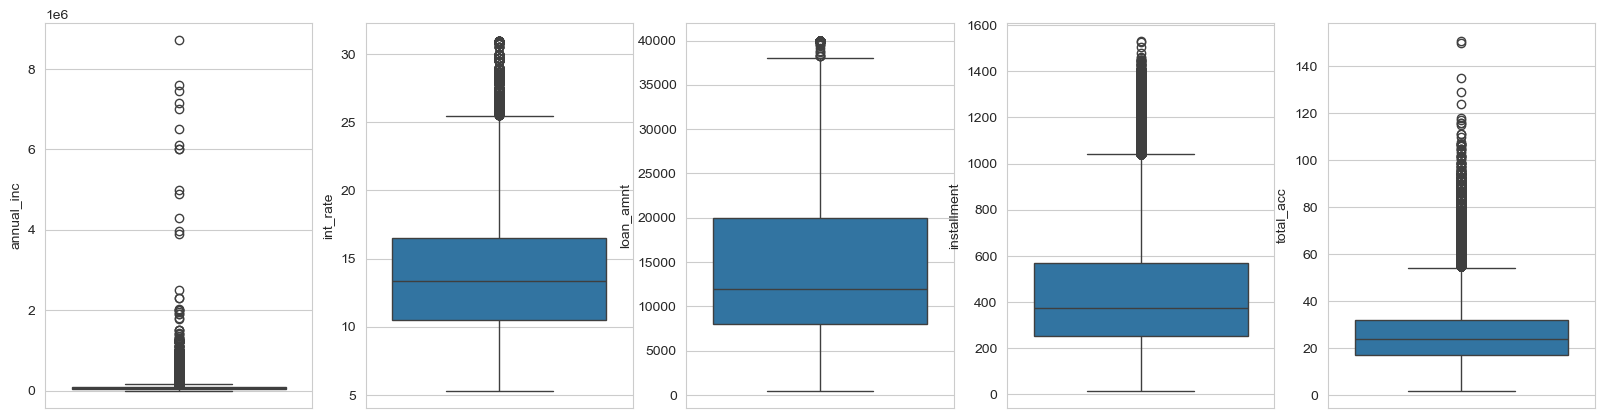

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
sns.boxplot(y='annual_inc', data=pdf, ax=ax[0]);
sns.boxplot(y='int_rate', data=pdf, ax=ax[1]);
sns.boxplot(y='loan_amnt', data=pdf, ax=ax[2]);
sns.boxplot(y='installment', data=pdf, ax=ax[3]);
sns.boxplot(y='total_acc', data=pdf, ax=ax[4]);

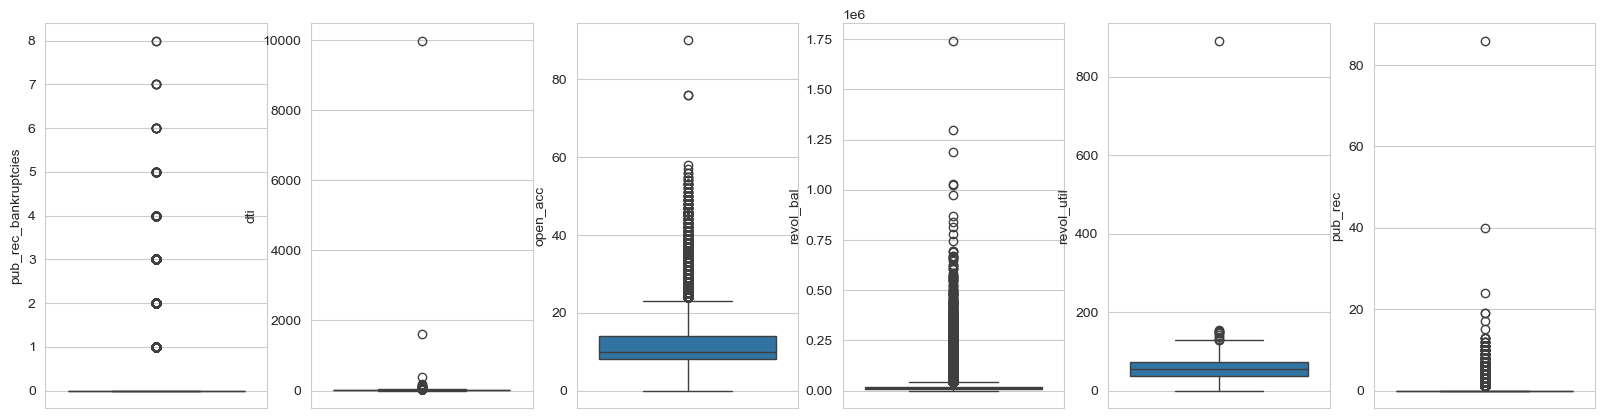

In [ ]:
c=['pub_rec_bankruptcies', 'dti', 'open_acc', 'revol_bal', 'revol_util', 'pub_rec']
fig, ax = plt.subplots(1, 6, figsize=(20, 5))

for i in range(6):
    sns.boxplot(y=c[i], data=pdf, ax=ax[i]);

## Normality Check

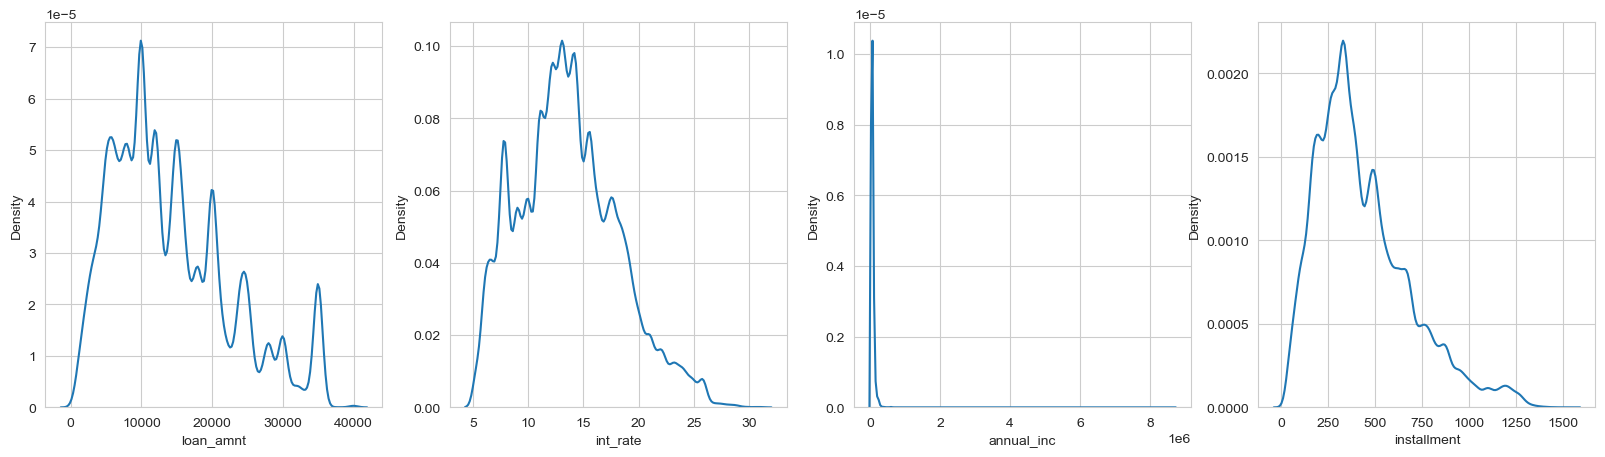

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
sns.kdeplot(x='loan_amnt', data=pdf, ax=ax[0]);
sns.kdeplot(x='int_rate', data=pdf, ax=ax[1]);
sns.kdeplot(x='annual_inc', data=pdf, ax=ax[2]);
sns.kdeplot(x='installment', data=pdf, ax=ax[3]);

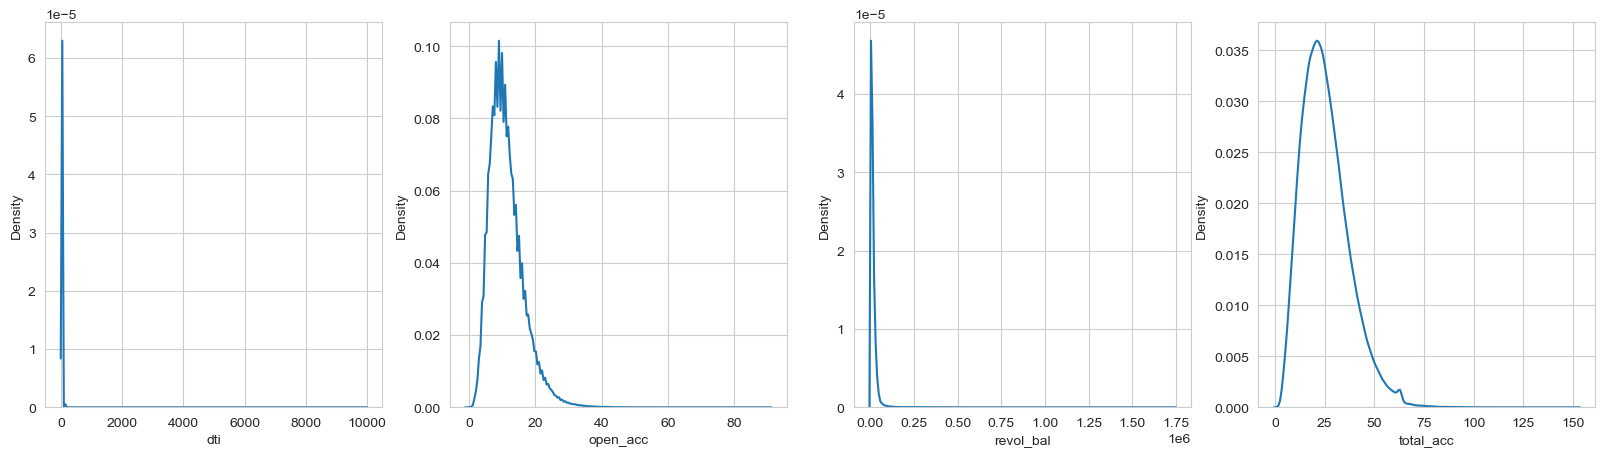

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
sns.kdeplot(x='dti', data=pdf, ax=ax[0]);
sns.kdeplot(x='open_acc', data=pdf, ax=ax[1]);
sns.kdeplot(x='revol_bal', data=pdf, ax=ax[2]);
sns.kdeplot(x='total_acc', data=pdf, ax=ax[3]);

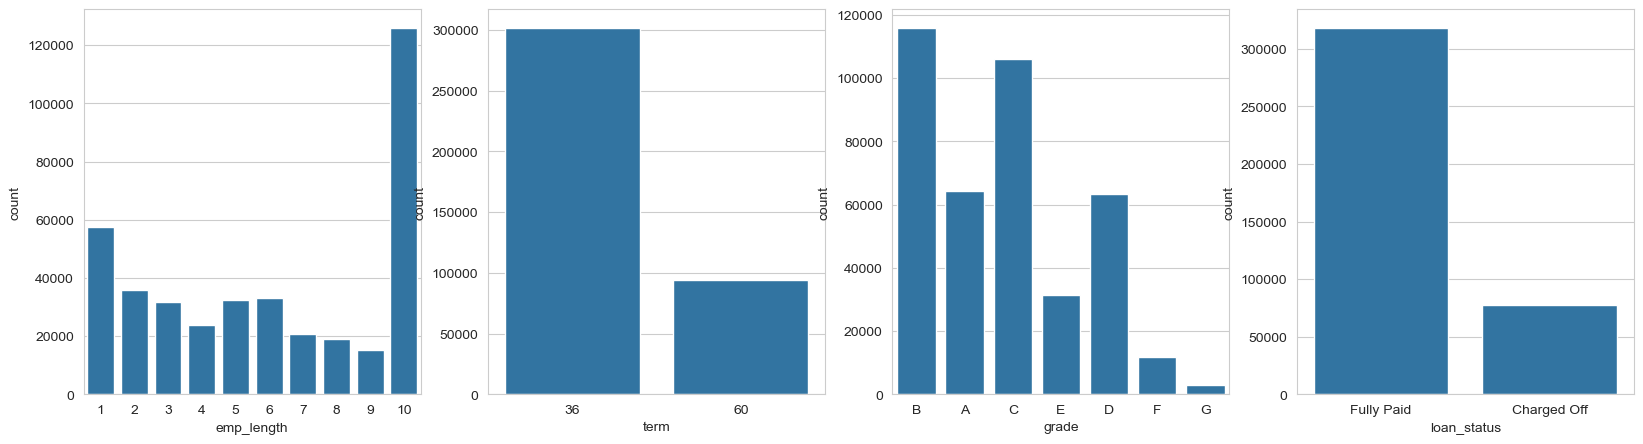

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
sns.countplot(x='emp_length', data=pdf, ax=ax[0]);
sns.countplot(x='term', data=pdf, ax=ax[1]);
sns.countplot(x='grade', data=pdf, ax=ax[2]);
sns.countplot(x='loan_status', data=pdf, ax=ax[3]);

<b style='padding: 2px 8px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>
- From above plot we can see that most loans are taken by users who are younger and decreases as experience increases

## Bivariate Analysis

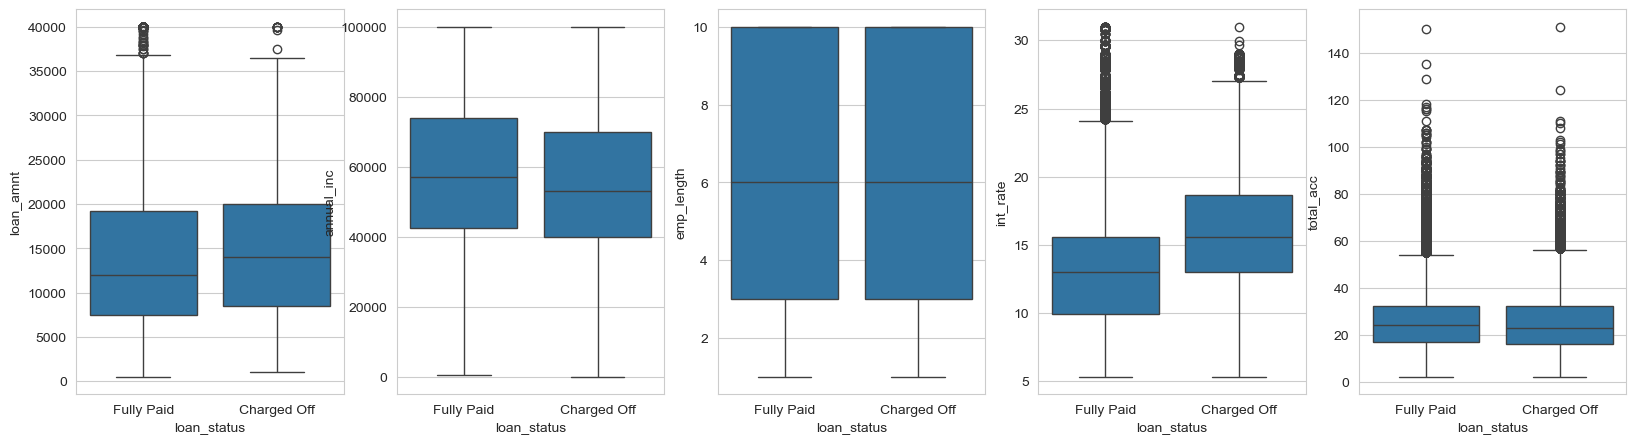

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
sns.boxplot(x='loan_status', y='loan_amnt', data=pdf, ax=ax[0]);
sns.boxplot(x='loan_status', y='annual_inc', data=pdf[pdf["annual_inc"]<100000], ax=ax[1]); #adjusting for outliers
sns.boxplot(x='loan_status', y='emp_length', data=pdf, ax=ax[2]);
sns.boxplot(x='loan_status', y='int_rate', data=pdf, ax=ax[3]);
sns.boxplot(x='loan_status', y='total_acc', data=pdf, ax=ax[4]);

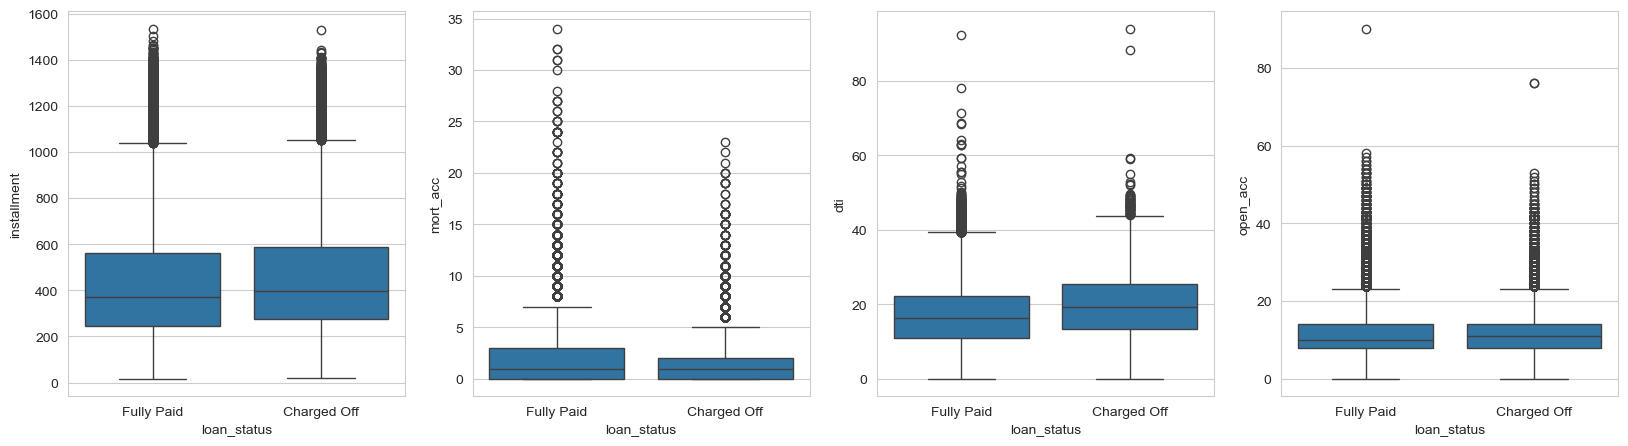

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
sns.boxplot(x='loan_status', y='installment', data=pdf, ax=ax[0]);
sns.boxplot(x='loan_status', y='mort_acc', data=pdf, ax=ax[1]);
sns.boxplot(x='loan_status', y='dti', data=pdf[pdf["dti"]<100], ax=ax[2]);
sns.boxplot(x='loan_status', y='open_acc', data=pdf, ax=ax[3]);

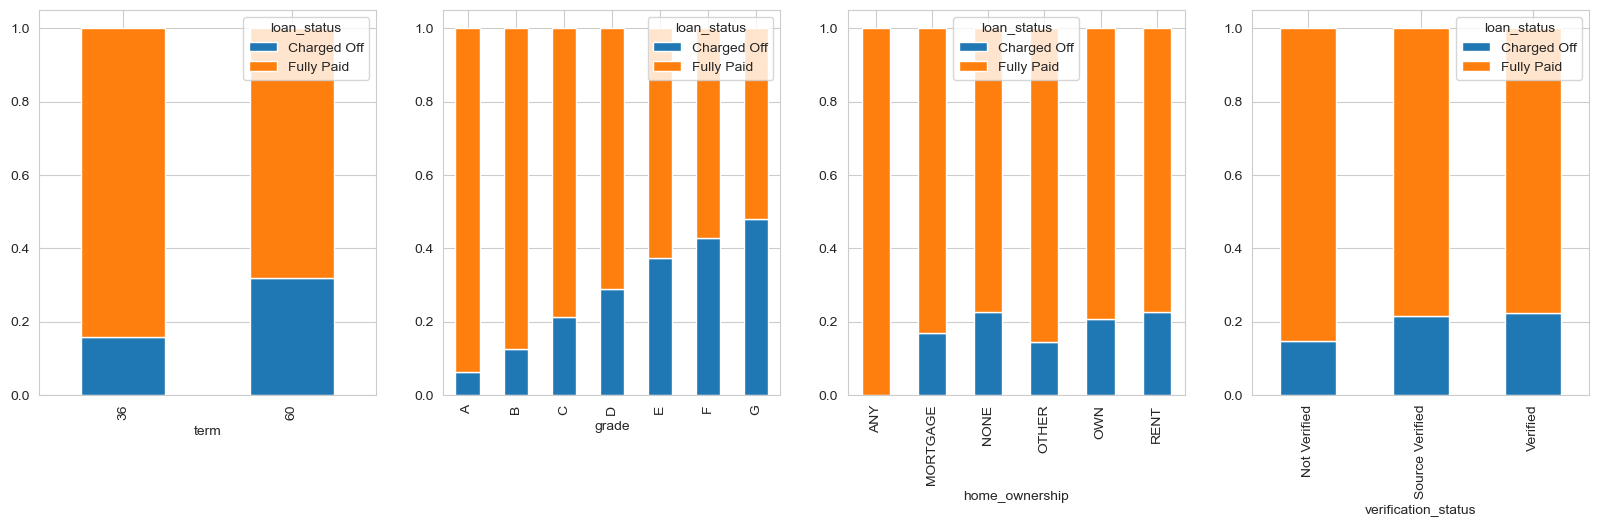

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
pd.crosstab(pdf['term'], pdf['loan_status'],normalize="index").plot(kind='bar', stacked=True, ax=ax[0]);
pd.crosstab(pdf['grade'], pdf['loan_status'], normalize="index").plot(kind='bar', stacked=True, ax=ax[1]);
pd.crosstab(pdf['home_ownership'], pdf['loan_status'], normalize="index").plot(kind='bar', stacked=True, ax=ax[2]);
pd.crosstab(pdf['verification_status'], pdf['loan_status'], normalize="index").plot(kind='bar', stacked=True, ax=ax[3]);

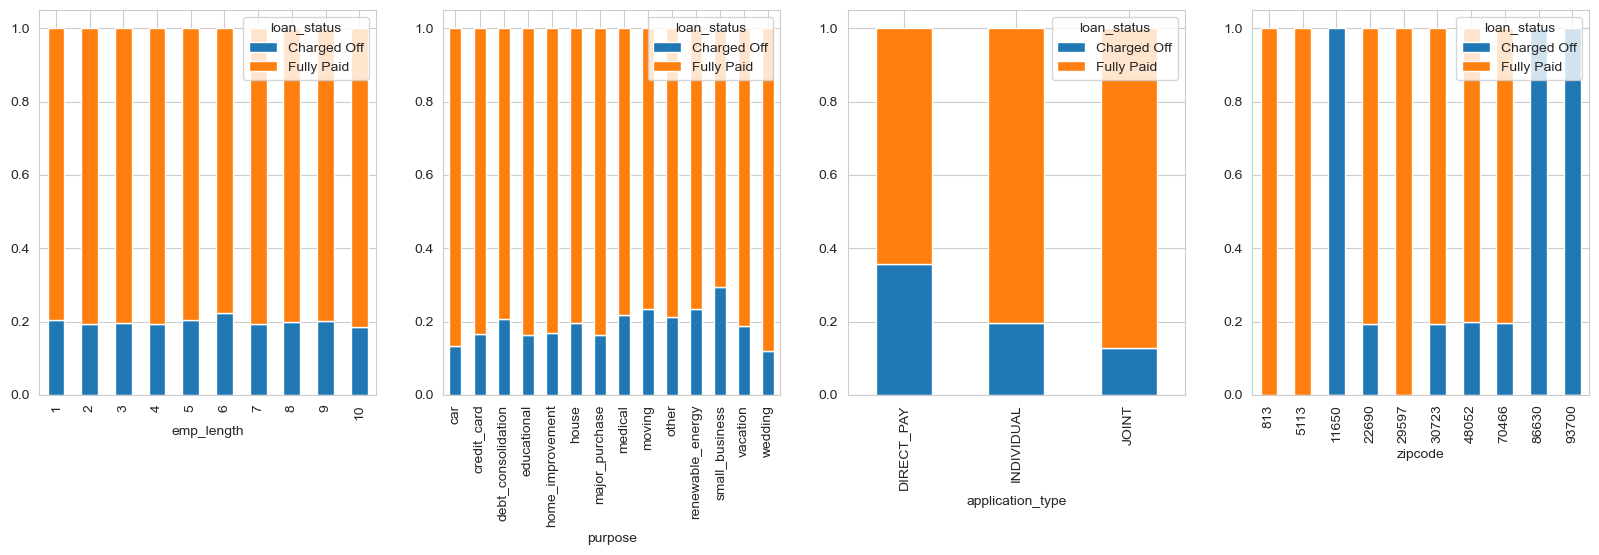

In [8]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
pd.crosstab(pdf['emp_length'], pdf['loan_status'], normalize="index").plot(kind='bar', stacked=True, ax=ax[0]);
pd.crosstab(pdf['purpose'], pdf['loan_status'], normalize="index").plot(kind='bar', stacked=True, ax=ax[1]);
pd.crosstab(pdf['application_type'], pdf['loan_status'], normalize="index").plot(kind='bar', stacked=True, ax=ax[2]);
pd.crosstab(pdf['zipcode'], pdf['loan_status'], normalize="index").plot(kind='bar', stacked=True , ax=ax[3]);

<b style='padding: 2px 8px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>
- We can see that there is equal proportion of loan paid off and charged off for employee experience
- We can see small business have highest percentage of "Charged Off" loans
- Above graph shows that zipcode can be an important feature in separating users on basis of loan status

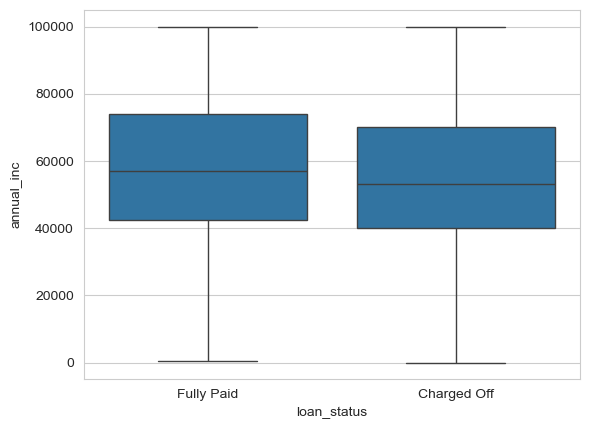

In [ ]:
sns.boxplot(x='loan_status', y='annual_inc', data=pdf[pdf["annual_inc"]<100000]);

<b style='padding: 2px 8px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>


In [ ]:
spark.sql("SELECT zipcode,  loan_status, COUNT(*) as count FROM data GROUP BY loan_status, zipcode order by zipcode").show()

+-------+-----------+-----+
|zipcode|loan_status|count|
+-------+-----------+-----+
|    813| Fully Paid|45824|
|   5113| Fully Paid|45402|
|  11650|Charged Off|11226|
|  22690| Fully Paid|45573|
|  22690|Charged Off|10954|
|  29597| Fully Paid|45471|
|  30723| Fully Paid|45525|
|  30723|Charged Off|11021|
|  48052|Charged Off|11192|
|  48052| Fully Paid|44725|
|  70466| Fully Paid|45837|
|  70466|Charged Off|11148|
|  86630|Charged Off|10981|
|  93700|Charged Off|11151|
+-------+-----------+-----+



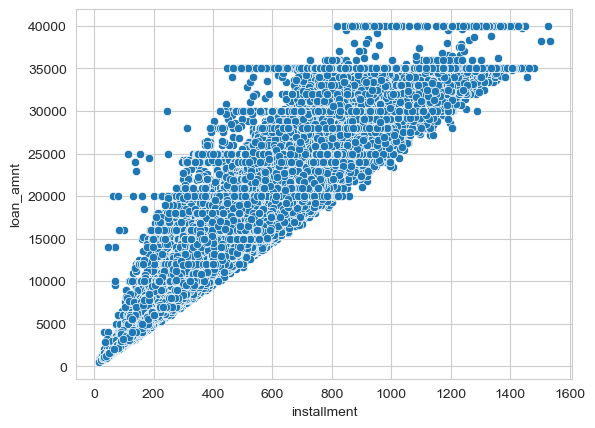

In [5]:
sns.scatterplot(x='installment', y='loan_amnt', data=pdf);

<b style='padding: 2px 8px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>


In [6]:
pdf.columns

Index(['grade', 'loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose', 'dti',
       'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'initial_list_status', 'application_type', 'mort_acc',
       'pub_rec_bankruptcies', 'city', 'state', 'zipcode', 'issue_year',
       'earliest_cr_line_year', 'issue_month', 'earliest_cr_line_month'],
      dtype='object')

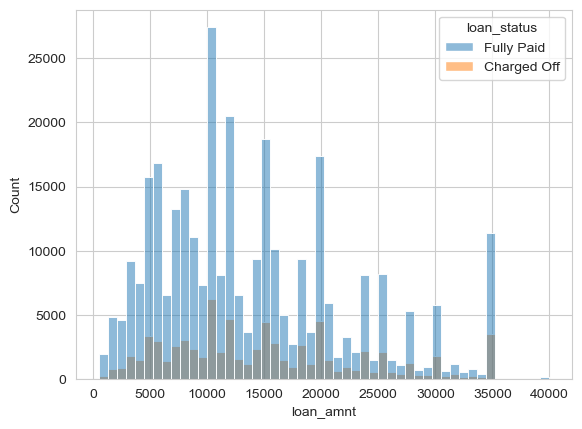

In [9]:
sns.histplot(x='loan_amnt', data=pdf, bins=50, hue='loan_status');

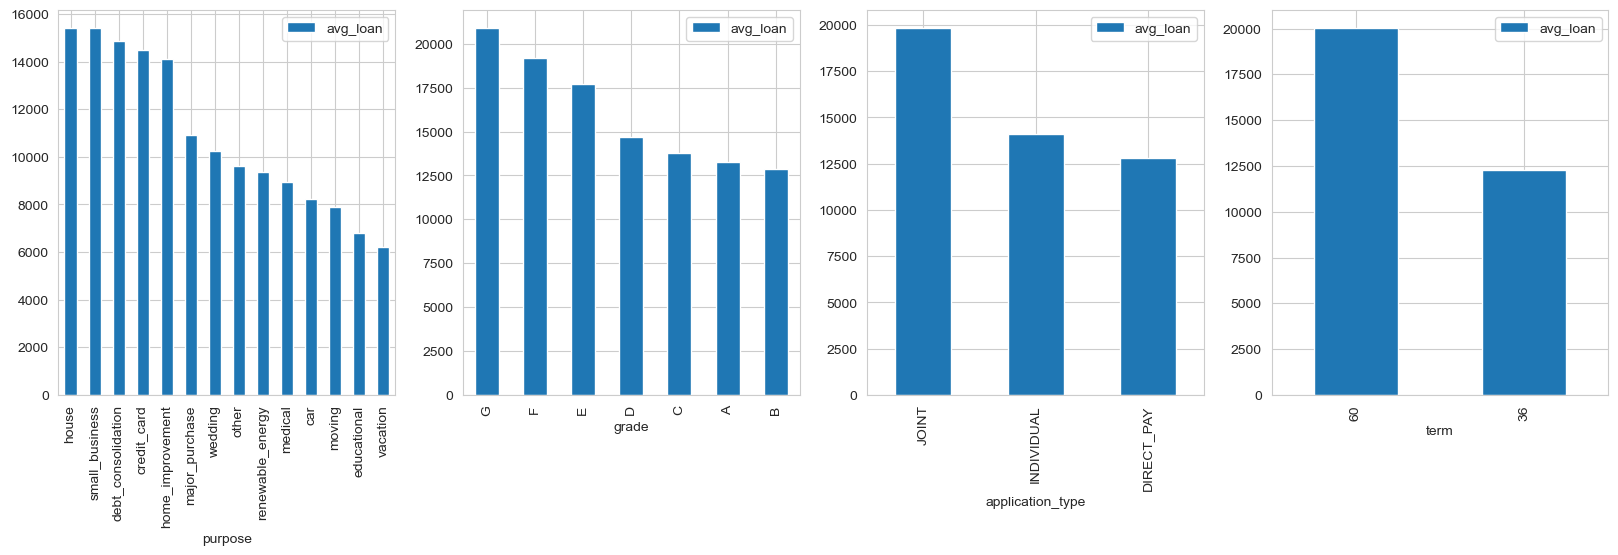

In [13]:
fig , ax = plt.subplots(1, 4, figsize=(20, 5))
spark.sql(""" 
select round(avg(loan_amnt),2) avg_loan, purpose  from data group by purpose order by avg_loan desc
""").toPandas().plot(kind='bar', x='purpose', y='avg_loan', ax=ax[0]);
spark.sql(""" 
select round(avg(loan_amnt),2) avg_loan, grade  from data group by grade order by avg_loan desc
""").toPandas().plot(kind='bar', x='grade', y='avg_loan', ax=ax[1]);

spark.sql(""" 
select round(avg(loan_amnt),2) avg_loan, application_type  from data group by application_type order by avg_loan desc
""").toPandas().plot(kind='bar', x='application_type', y='avg_loan', ax=ax[2]);
spark.sql(""" 
select round(avg(loan_amnt),2) avg_loan, term  from data group by term order by avg_loan desc
""").toPandas().plot(kind='bar', x='term', y='avg_loan', ax=ax[3]);


<b style='padding: 2px 8px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>
- We can see that average loan ammount for users is highest for houses and lowest for vacations

# Model Building

In [7]:
df_model = spark.read.parquet("logistic_regression_cleaned.parquet")
df_model.cache();
# https://saturncloud.io/blog/feature-selection-in-pyspark-a-comprehensive-guide-for-data-scientists/

In [8]:
df_model.show(5)

+-----+---------+----+--------+-----------+---------+--------------------+----------+--------------+----------+-------------------+----------+-----------+------------------+-----+----------------+--------+-------+---------+----------+---------+-------------------+----------------+--------+--------------------+------------+-----+-------+----------+---------------------+-----------+----------------------+
|grade|loan_amnt|term|int_rate|installment|sub_grade|           emp_title|emp_length|home_ownership|annual_inc|verification_status|   issue_d|loan_status|           purpose|  dti|earliest_cr_line|open_acc|pub_rec|revol_bal|revol_util|total_acc|initial_list_status|application_type|mort_acc|pub_rec_bankruptcies|        city|state|zipcode|issue_year|earliest_cr_line_year|issue_month|earliest_cr_line_month|
+-----+---------+----+--------+-----------+---------+--------------------+----------+--------------+----------+-------------------+----------+-----------+------------------+-----+-------

**Outlier Treatment**

In [9]:
df_model = df_model.filter("dti < 50")
df_model = df_model.withColumn("annual_inc", sf.log1p(df_model["annual_inc"]))
df_model = df_model.withColumn("revol_bal", sf.log1p(df_model["revol_bal"]))
df_model = df_model.withColumn("total_acc", sf.log(df_model["total_acc"]))
df_model = df_model.filter("revol_util < 200")
df_model = df_model.withColumn("loan_amnt", sf.log(df_model["loan_amnt"]))
df_model = df_model.withColumn("installment", sf.log(df_model["installment"]))
df_model = df_model.withColumn("open_acc", sf.log1p(df_model["open_acc"]))

**Drop Columns**

In [10]:
drop_cols=['issue_d', 'emp_title',  'earliest_cr_line', 'emp_title', 'grade','city' ]
df_model = df_model.drop(*drop_cols)

**Encodings**

In [11]:
sub_grade = df_model.select("sub_grade").distinct().sort("sub_grade")
indexer = StringIndexer(inputCol="sub_grade", outputCol="sub_grade_index")
indexer_model = indexer.fit(sub_grade)
df_encoded = indexer_model.transform(sub_grade)

In [12]:
df_model = indexer_model.transform(df_model)
df_model=df_model.drop("sub_grade")
df_model = df_model.withColumn("sub_grade", df_model["sub_grade_index"].cast(IntegerType()))
df_model = df_model.drop("sub_grade_index")

In [13]:
df_model = df_model.withColumn("loan_status", sf.when(df_model["loan_status"] == "Fully Paid", 0).otherwise(1).cast(IntegerType()))
df_model = df_model.withColumn("term", sf.when(df_model["term"] == 36, 0).otherwise(1).cast(IntegerType()))
df_model = df_model.withColumn("application_type", sf.when(df_model["application_type"] == "INDIVIDUAL", 0).otherwise(1).cast(IntegerType()))
df_model = df_model.withColumn("initial_list_status", sf.when(df_model["initial_list_status"] == "w", 0).otherwise(1).cast(IntegerType()))

In [14]:
df_model = df_model.withColumn("issue_month_sin", sf.sin((df_model.issue_month-1)*(2.*np.pi/12)))
df_model = df_model.withColumn("issue_month_cos", sf.cos((df_model.issue_month-1)*(2.*np.pi/12)))
df_model = df_model.withColumn("earliest_cr_line_month_sin", sf.sin((df_model.earliest_cr_line_month-1)*(2.*np.pi/12)))
df_model = df_model.withColumn("earliest_cr_line_month_cos", sf.cos((df_model.earliest_cr_line_month-1)*(2.*np.pi/12)))
df_model = df_model.drop("issue_month", "earliest_cr_line_month")

In [15]:
def target_mean_encoding(df, col, target):
    """
    :param df: pyspark.sql.dataframe
        dataframe to apply target mean encoding
    :param col: str list
        list of columns to apply target encoding
    :param target: str
        target column
    :return:
        dataframe with target encoded columns
    """
    target_encoded_columns_list = []
    for c in col:
        means = df.groupby(sf.col(c)).agg(sf.mean(target).alias(f"{c}_mean_encoding"))
        dict_ = means.toPandas().to_dict()
        target_encoded_columns = [sf.when(sf.col(c) == v, encoder)
                                  for v, encoder in zip(dict_[c].values(),dict_[f"{c}_mean_encoding"].values())]
        target_encoded_columns_list.append(sf.coalesce(*target_encoded_columns).alias(f"{c}_mean_encoding"))
    return df.select(*col, *target_encoded_columns_list).distinct()

In [16]:
df_target_encoded = target_mean_encoding(df_model, col=['state'], target='loan_status')

In [17]:
df_model = df_model.join(df_target_encoded, "state")
df_model = df_model.drop("state")
df_model = df_model.withColumnRenamed("state_mean_encoding", "state")

In [18]:
df_model.show(5)

+------------------+----+--------+------------------+----------+--------------+------------------+-------------------+-----------+------------------+-----+------------------+-------+------------------+----------+------------------+-------------------+----------------+--------+--------------------+-------+----------+---------------------+---------+------------------+--------------------+--------------------------+--------------------------+-------------------+
|         loan_amnt|term|int_rate|       installment|emp_length|home_ownership|        annual_inc|verification_status|loan_status|           purpose|  dti|          open_acc|pub_rec|         revol_bal|revol_util|         total_acc|initial_list_status|application_type|mort_acc|pub_rec_bankruptcies|zipcode|issue_year|earliest_cr_line_year|sub_grade|   issue_month_sin|     issue_month_cos|earliest_cr_line_month_sin|earliest_cr_line_month_cos|              state|
+------------------+----+--------+------------------+----------+--------

In [19]:
df_model.write.parquet("df_model.parquet", mode='overwrite')

In [20]:
df_model = pd.read_parquet("df_model.parquet")
df_model.head()

,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,zipcode,issue_year,earliest_cr_line_year,sub_grade,issue_month_sin,issue_month_cos,earliest_cr_line_month_sin,earliest_cr_line_month_cos,state
0,9.210340,0,11.44,5.797516,10,RENT,11.669938,Not Verified,0,vacation,26.24,2.833213,0,10.501500,41.8,3.218876,0,0,0,0,22690,2015,2015,8,0.000000,1.000000e+00,0.000000,1.000000e+00,0.192013
1,8.987197,0,11.99,5.582293,4,MORTGAGE,11.082158,Not Verified,0,debt_consolidation,22.05,2.890372,0,9.910066,53.3,3.295837,1,0,3,0,05113,2015,2015,9,0.000000,1.000000e+00,0.000000,1.000000e+00,0.197067
2,9.655026,0,10.49,6.228452,1,RENT,10.670303,Source Verified,0,credit_card,12.79,2.639057,0,9.391661,92.2,3.258097,1,0,0,0,05113,2015,2015,7,0.000000,1.000000e+00,0.000000,1.000000e+00,0.203976
3,8.881836,0,6.49,5.396578,6,RENT,10.896758,Not Verified,0,credit_card,2.60,1.945910,0,8.607582,21.5,2.564949,1,0,0,0,00813,2014,2014,1,-0.866025,5.000000e-01,-0.866025,5.000000e-01,0.195983
4,10.101313,1,17.27,6.412360,9,MORTGAGE,10.915107,Verified,1,credit_card,33.95,2.639057,0,10.109892,69.8,3.761200,1,0,1,0,11650,2013,2013,14,1.000000,6.123234e-17,1.000000,6.123234e-17,0.195129


In [21]:
df_model["was_bankrupt"] = df_model["pub_rec_bankruptcies"].apply(lambda x: 1 if x > 0 else 0)
df_model["has_pub_rec"] = df_model["pub_rec"].apply(lambda x: 1 if x > 0 else 0)
df_model = df_model.drop(["pub_rec_bankruptcies", "pub_rec"], axis=1)

In [22]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395994 entries, 0 to 395993
Data columns (total 29 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   loan_amnt                   395994 non-null  float64
 1   term                        395994 non-null  int32  
 2   int_rate                    395994 non-null  float64
 3   installment                 395994 non-null  float64
 4   emp_length                  395994 non-null  int32  
 5   home_ownership              395994 non-null  object 
 6   annual_inc                  395994 non-null  float64
 7   verification_status         395994 non-null  object 
 8   loan_status                 395994 non-null  int32  
 9   purpose                     395994 non-null  object 
 10  dti                         395994 non-null  float64
 11  open_acc                    395994 non-null  float64
 12  revol_bal                   395994 non-null  float64
 13  revol_util    

In [23]:
df_model["loan_status"].value_counts(normalize=True)

loan_status
0    0.803876
1    0.196124
Name: proportion, dtype: float64

In [25]:
oneHotEncoder = OneHotEncoder()
oneHotEncoder.fit(df_model[["home_ownership", "verification_status", "purpose", "zipcode"]])
df_encoded = oneHotEncoder.transform(df_model[["home_ownership", "verification_status", "purpose", "zipcode"]])
df_encoded_dataframe = pd.DataFrame(df_encoded.toarray(), columns=oneHotEncoder.get_feature_names_out(["home_ownership", "verification_status", "purpose", "zipcode"]))

OneHotEncoder()

**Finding Correlation**

In [26]:
cols=df_model.select_dtypes(include=['int64', 'int32', "float64"]).columns

In [27]:
corr = df_model[cols].corr()

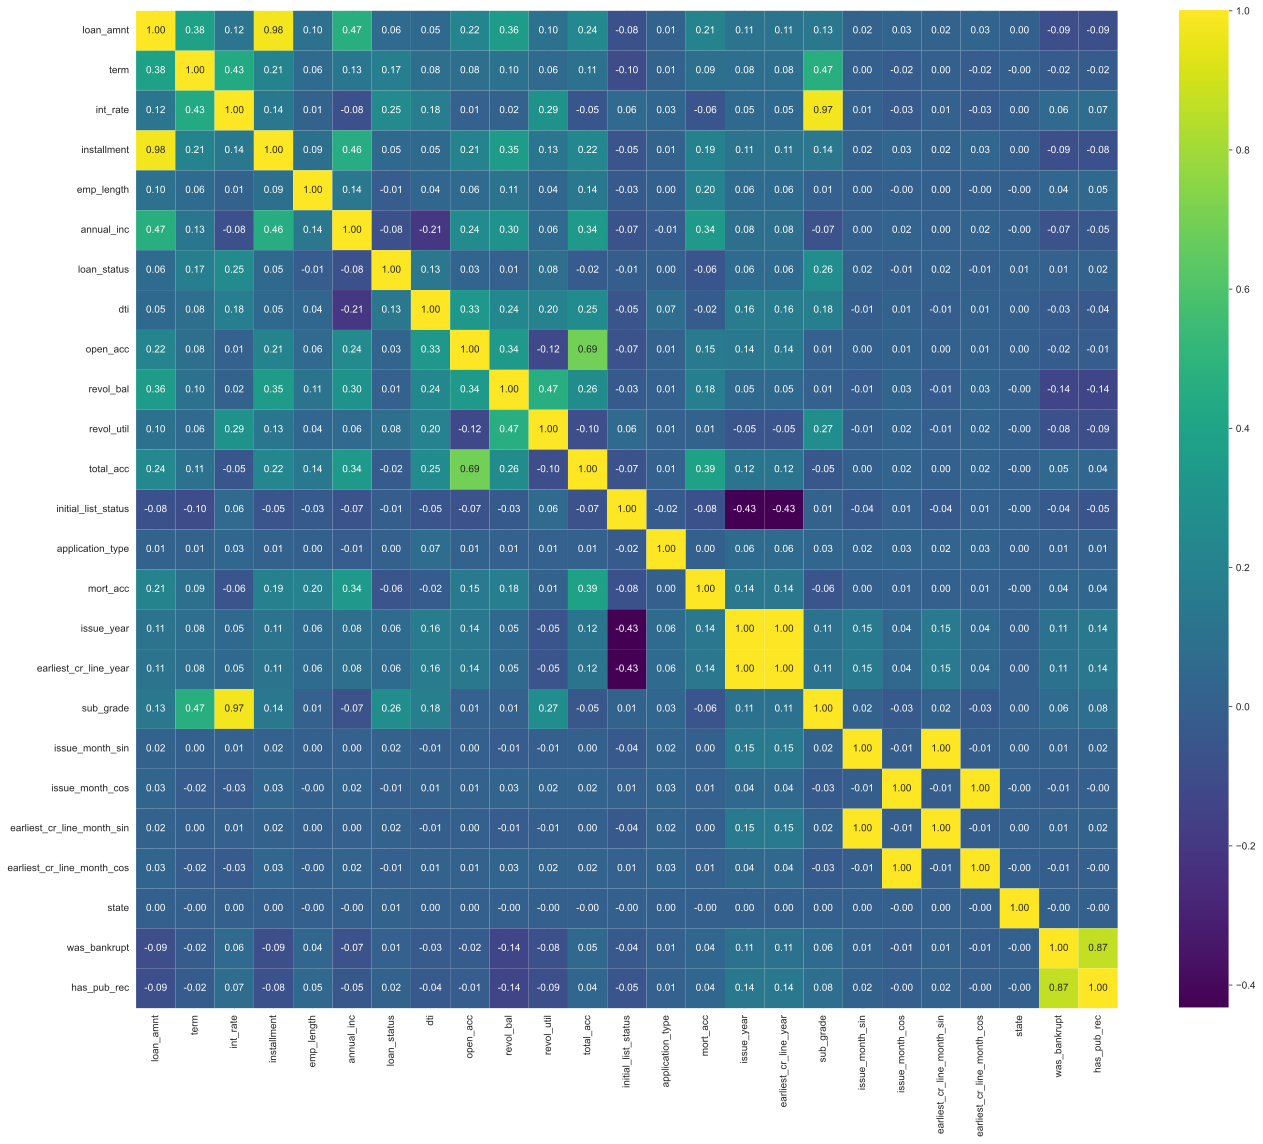

In [28]:
plt.figure(figsize=(22, 18))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='viridis');

**Dropping Correlated Features**

In [29]:
to_drop = ["loan_amnt", "int_rate", "issue_month_cos", "issue_month_sin", "issue_year"]
df_model = df_model.drop(to_drop, axis=1)

In [30]:
df_model = pd.concat([df_model, df_encoded_dataframe], axis=1)
df_model = df_model.drop(["home_ownership", "verification_status", "purpose", "zipcode"], axis=1)

In [31]:
df_model

,term,installment,emp_length,annual_inc,loan_status,dti,open_acc,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,earliest_cr_line_year,sub_grade,earliest_cr_line_month_sin,earliest_cr_line_month_cos,state,was_bankrupt,has_pub_rec,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,zipcode_00813,zipcode_05113,zipcode_11650,zipcode_22690,zipcode_29597,zipcode_30723,zipcode_48052,zipcode_70466,zipcode_86630,zipcode_93700
0,0,5.797516,10,11.669938,0,26.24,2.833213,10.501500,41.8,3.218876,0,0,0,2015,8,0.000000,1.000000e+00,0.192013,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,5.582293,4,11.082158,0,22.05,2.890372,9.910066,53.3,3.295837,1,0,3,2015,9,0.000000,1.000000e+00,0.197067,0,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,6.228452,1,10.670303,0,12.79,2.639057,9.391661,92.2,3.258097,1,0,0,2015,7,0.000000,1.000000e+00,0.203976,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,5.396578,6,10.896758,0,2.60,1.945910,8.607582,21.5,2.564949,1,0,0,2014,1,-0.866025,5.000000e-01,0.195983,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,6.412360,9,10.915107,1,33.95,2.639057,10.109892,69.8,3.761200,1,0,1,2013,14,1.000000,6.123234e-17,0.195129,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395989,1,5.381647,2,10.596660,0,15.63,1.945910,7.596392,34.3,3.135494,0,0,0,2015,8,-1.000000,-1.836970e-16,0.195557,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
395990,0,6.551680,5,11.608245,0,21.45,1.945910,10.675076,95.7,2.079442,1,0,1,2015,10,0.500000,8.660254e-01,0.193690,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
395991,0,5.083390,10,10.942014,0,17.56,2.772589,10.395283,66.9,3.135494,1,0,0,2013,5,-1.000000,-1.836970e-16,0.186492,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
395992,1,6.220630,10,11.066654,0,15.88,2.302585,9.661734,53.8,2.995732,1,0,5,2012,11,-0.500000,-8.660254e-01,0.193469,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [32]:
# df_model.to_parquet("df_model_v2.parquet")

In [34]:
X_train, X_test, y_train, y_test = train_test_split(df_model.drop("loan_status", axis=1), df_model["loan_status"], test_size=0.2, random_state=42)

In [35]:
min_max_scale_cols = ['earliest_cr_line_year', 'emp_length', 'sub_grade']
standard_scale_cols = ['annual_inc', 'dti',  'installment', 'mort_acc', 'open_acc',  'revol_bal', 'revol_util', 'total_acc']

In [36]:
def perform_scaling(scaler, X_train, X_test, cols):
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    X_train_scaled[cols] = scaler.fit_transform(X_train[cols])
    X_test_scaled[cols] = scaler.transform(X_test[cols])
    return X_train_scaled, X_test_scaled

In [37]:
X_train, X_test = perform_scaling(MinMaxScaler(), X_train, X_test, min_max_scale_cols)
X_train, X_test = perform_scaling(StandardScaler(), X_train, X_test, standard_scale_cols)

In [38]:
X_train.head()

,term,installment,emp_length,annual_inc,dti,open_acc,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,earliest_cr_line_year,sub_grade,earliest_cr_line_month_sin,earliest_cr_line_month_cos,state,was_bankrupt,has_pub_rec,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,zipcode_00813,zipcode_05113,zipcode_11650,zipcode_22690,zipcode_29597,zipcode_30723,zipcode_48052,zipcode_70466,zipcode_86630,zipcode_93700
260099,0,-1.035851,1.000000,1.015283,-0.212362,0.139226,-0.564297,0.674953,1.181109,0,0,-0.805690,1.000000,0.264706,5.000000e-01,8.660254e-01,0.208135,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
191574,0,0.108203,0.555556,0.223086,-0.139705,1.500778,0.147268,-0.162764,2.035420,1,0,-0.805690,0.555556,0.382353,1.000000e+00,6.123234e-17,0.194773,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
60165,0,1.336667,0.333333,1.547257,0.317171,2.368571,0.931469,0.654521,1.181109,0,0,-0.805690,0.777778,0.117647,1.224647e-16,-1.000000e+00,0.193934,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5065,1,-1.107012,0.333333,-2.243133,-0.575647,-2.533709,-0.466009,1.271572,-1.834592,1,0,-0.805690,0.333333,0.558824,-1.000000e+00,-1.836970e-16,0.195210,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
336914,0,-3.749634,0.555556,-0.674791,-1.229559,1.257273,-1.211843,-1.891323,0.492437,1,0,0.151278,0.666667,0.147059,-8.660254e-01,-5.000000e-01,0.194263,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [39]:
X_train.columns

Index(['term', 'installment', 'emp_length', 'annual_inc', 'dti', 'open_acc',
       'revol_bal', 'revol_util', 'total_acc', 'initial_list_status',
       'application_type', 'mort_acc', 'earliest_cr_line_year', 'sub_grade',
       'earliest_cr_line_month_sin', 'earliest_cr_line_month_cos', 'state',
       'was_bankrupt', 'has_pub_rec', 'home_ownership_ANY',
       'home_ownership_MORTGAGE', 'home_ownership_NONE',
       'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT',
       'verification_status_Not Verified',
       'verification_status_Source Verified', 'verification_status_Verified',
       'purpose_car', 'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_educational', 'purpose_home_improvement', 'purpose_house',
       'purpose_major_purchase', 'purpose_medical', 'purpose_moving',
       'purpose_other', 'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding', 'zipcode_00813', 'zipcode_05113',
       '

In [47]:
vif_cols = ['term', 'installment', 'emp_length', 'annual_inc', 'dti', 'open_acc',
       'revol_bal', 'revol_util', 'total_acc', 'initial_list_status',
       'application_type', 'mort_acc', 'earliest_cr_line_year', 'sub_grade',
       'earliest_cr_line_month_sin', 'earliest_cr_line_month_cos', 'state',
       'was_bankrupt', 'has_pub_rec']

In [41]:
X_vif = pd.DataFrame(X_train[vif_cols], columns=vif_cols)
vif = pd.DataFrame()

vif['Features'] = X_vif.columns
vif['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
16,state,38.23
12,earliest_cr_line_year,28.69
13,sub_grade,6.09
18,has_pub_rec,4.85
17,was_bankrupt,4.63
2,emp_length,3.31
9,initial_list_status,3.14
8,total_acc,2.43
5,open_acc,2.43
6,revol_bal,1.89


In [48]:
vif_cols =list(set(vif_cols) - set(["state", "earliest_cr_line_year"]))

X_vif = pd.DataFrame(X_train[vif_cols], columns=vif_cols)
vif = pd.DataFrame()

vif['Features'] = X_vif.columns
vif['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
16,has_pub_rec,4.81
8,was_bankrupt,4.63
13,sub_grade,3.99
5,emp_length,2.44
2,open_acc,2.43
15,total_acc,2.43
9,initial_list_status,2.12
3,revol_bal,1.86
12,term,1.82
0,annual_inc,1.72


In [50]:
vif_cols

['annual_inc',
 'earliest_cr_line_month_cos',
 'open_acc',
 'revol_bal',
 'application_type',
 'emp_length',
 'mort_acc',
 'revol_util',
 'was_bankrupt',
 'initial_list_status',
 'dti',
 'installment',
 'term',
 'sub_grade',
 'earliest_cr_line_month_sin',
 'total_acc',
 'has_pub_rec']

In [51]:
X_train = X_train.drop(["state", "earliest_cr_line_year"], axis=1)
X_test = X_test.drop(["state", "earliest_cr_line_year"], axis=1)

In [121]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve, auc, ConfusionMatrixDisplay

In [85]:
penalty = ['l1', 'l2']
lambdas = [0.01, 0.1, 1, 10, 100, 1000, 10000]
C_values = [1/lambda_val for lambda_val in lambdas]
param_grid = {'C': C_values, 'penalty': [penalty]}
model = LogisticRegression(max_iter=1000 , penalty=penalty, class_weight={1: 8, 0: 2}, solver='liblinear', n_jobs=-1)

In [88]:
grid_search = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=[], verbose=3)
grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 7 candidates, totalling 14 fits


[CV 1/2] END ..........................C=0.0001;, score=0.557 total time=   4.2s
[CV 2/2] END ..........................C=0.0001;, score=0.559 total time=   4.4s
[CV 2/2] END ...........................C=100.0;, score=0.622 total time=   9.3s
[CV 1/2] END ...........................C=0.001;, score=0.622 total time=   9.7s
[CV 1/2] END ............................C=10.0;, score=0.625 total time=  10.1s
[CV 2/2] END ............................C=10.0;, score=0.622 total time=  10.1s
[CV 1/2] END ...........................C=100.0;, score=0.624 total time=  10.1s
[CV 2/2] END ...........................C=0.001;, score=0.619 total time=  11.0s
[CV 1/2] END ............................C=0.01;, score=0.624 total time=  19.2s
[CV 2/2] END ............................C=0.01;, score=0.622 total time=  22.4s
[CV 1/2] END .............................C=1.0;, score=0.625 total time=  54.0s
[CV 1/2] END .............................C=0.1;, score=0.625 total time=  57.0s
[CV 2/2] END ...............

GridSearchCV(cv=2,
             estimator=LogisticRegression(class_weight={0: 2, 1: 8},
                                          max_iter=1000, n_jobs=1, penalty='l1',
                                          solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': [100.0, 10.0, 1.0, 0.1, 0.01, 0.001, 0.0001]},
             scoring='f1', verbose=3)

In [89]:
grid_search.best_params_

{'C': 0.1}

**Training Model with Updated values**

In [93]:
model = LogisticRegression(max_iter=1000 , C=grid_search.best_params_['C'],  penalty=penalty, class_weight={1: 8, 0: 2}, solver='liblinear', n_jobs=-1)
model.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight={0: 2, 1: 8}, max_iter=1000, n_jobs=1,
                   penalty='l1', solver='liblinear')

In [142]:
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
y_test_prob = model.predict_proba(X_test)
y_train_prob = model.predict_proba(X_train)

**Calculate best threshold based on f1 score**

In [155]:
thresholds = np.arange(0.0, 1.0, 0.01)

precisions = []
recalls = []
f1s = []

for threshold in thresholds:
    _y_test_pred = (y_test_prob[:, 1] >= threshold).astype(int)
    precisions.append(precision_score(y_test, _y_test_pred))
    recalls.append(recall_score(y_test, _y_test_pred))
    f1s.append(f1_score(y_test, _y_test_pred))
    
best_threshold = thresholds[np.argmax(f1s)]

print(f'Best threshold: {best_threshold}')
print(f'Precision at best threshold: {precisions[np.argmax(f1s)]}')
print(f'Recall at best threshold: {recalls[np.argmax(f1s)]}')
print(f'F1 score at best threshold: {f1s[np.argmax(f1s)]}')

**Use best threshold**

In [136]:
y_test_pred = (y_test_prob[:, 1] >= best_threshold).astype(int)
y_train_pred = (y_train_prob[:, 1] >= best_threshold).astype(int)

**Feature Importance**

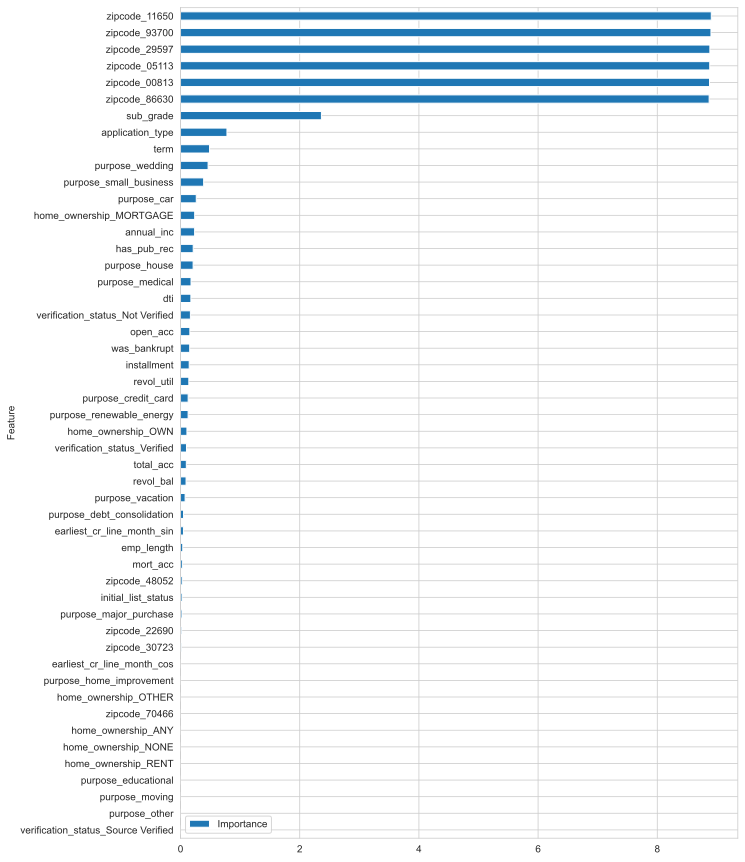

In [129]:
coefficients = model.coef_[0]
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 15));

# Results Evaluation

**ROC Curve**

In [137]:
fpr, tpr, threshold = roc_curve(y_test, y_test_prob[:,1], pos_label=1)

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

auc_score = roc_auc_score(y_test, y_test_prob[:,1])
print("AUC Score: ",auc_score)

AUC Score:  0.9061917995316591


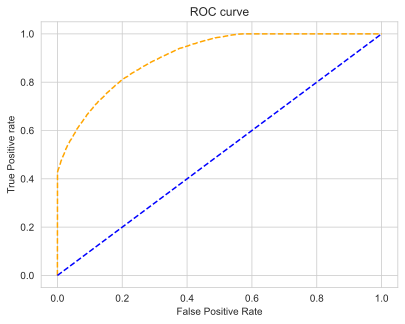

In [101]:
plt.plot(fpr, tpr, linestyle='--',color='orange', label='Logistic Regression')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.show();

**Precision recall Curve**

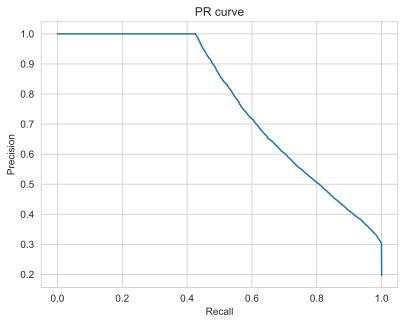

In [135]:
precision, recall, thr = precision_recall_curve(y_test, y_test_prob[:,1])
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR curve')
plt.show();

**Confusion Matrix**

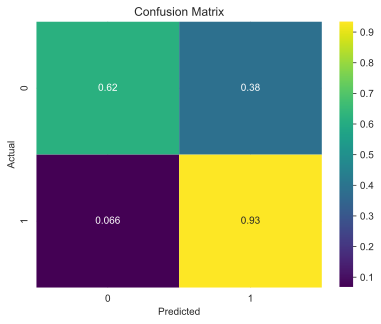

In [138]:
cm = confusion_matrix(y_test, y_test_pred,  normalize='true', labels=[1, 0])
sns.heatmap(cm, annot=True, cmap='viridis');
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual');

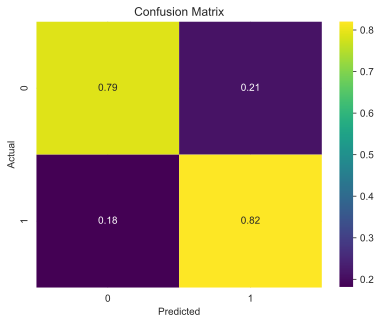

In [143]:
cm = confusion_matrix(y_test, y_test_pred,  normalize='true', labels=[1, 0])
sns.heatmap(cm, annot=True, cmap='viridis');
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual');

**Test Classification Report**

In [139]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92     63635
           1       0.69      0.62      0.65     15564

    accuracy                           0.87     79199
   macro avg       0.80      0.78      0.79     79199
weighted avg       0.87      0.87      0.87     79199



**Train Classification Report**

In [140]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92    254695
           1       0.69      0.62      0.66     62100

    accuracy                           0.87    316795
   macro avg       0.80      0.78      0.79    316795
weighted avg       0.87      0.87      0.87    316795



In [141]:
scores = {
    "f1":{
        "test": f1_score(y_test, y_test_pred),
        "train": f1_score(y_train, y_train_pred)
    },
    "precision":{
        "test": precision_score(y_test, y_test_pred),
        "train": precision_score(y_train, y_train_pred)
    },
    "recall":{
        "test": recall_score(y_test, y_test_pred),
        "train": recall_score(y_train, y_train_pred)
    },
    "auc":{
        "test": roc_auc_score(y_test, y_test_prob[:,1]),
        "train": roc_auc_score(y_train, y_train_prob[:,1])
    }
}
pd.DataFrame(scores)

,f1,precision,recall,auc
test,0.653989,0.694961,0.617579,0.906192
train,0.655868,0.694787,0.621079,0.906762


In [ ]:
To increase precision,  we have to decrease the false positives. 
False positives increase when model predicts a loan will be paid off but it is not.

To increase recall, we have to decrease the false negatives.
false negative increase when model predicts loan will not be paid off but it is paid off.

In [ ]:
Increasing Precision:

Precision is the ratio of true positives (correctly predicted positive instances) to the total predicted positives (true positives + false positives).
To increase precision, you need to decrease the number of false positives. In the context of loan predictions:
A false positive occurs when the model predicts that a loan will be paid off (positive prediction) but it is not paid off (negative actual).
Reducing these false positives (incorrectly predicted paid-off loans) will increase precision.
Increasing Recall:

Recall is the ratio of true positives to the total actual positives (true positives + false negatives).
To increase recall, you need to decrease the number of false negatives. In the context of loan predictions:
A false negative occurs when the model predicts that a loan will not be paid off (negative prediction) but it is actually paid off (positive actual).
Reducing these false negatives (missed paid-off loans) will increase recall.
To summarize:

Precision: Focus on minimizing false positives (loans predicted to be paid off but actually defaulted).
Recall: Focus on minimizing false negatives (loans predicted to default but actually paid off).
Balancing precision and recall often involves trade-offs, and the choice of threshold can help you achieve the desired balance depending on your specific goals.

In [ ]:
To increase bank profitability with respect to precision, recall, and the threshold for loan predictions, 
it's important to find a balance that minimizes losses from defaults (false positives) while maximizing the issuance of good loans (true positives). Here are some strategies:

Understanding the Impact on Profitability
False Positives (Type I Error):

When a loan is predicted to be paid off but defaults, the bank loses money due to non-repayment.
Reducing false positives is critical to minimizing these losses.
False Negatives (Type II Error):

When a loan is predicted to default but is actually paid off, the bank loses potential revenue from interest on that loan.
Reducing false negatives ensures the bank doesn't miss out on profitable lending opportunities.
